<!--NAVIGATION-->
< [Fancy Indexing](02.07-Fancy-Indexing.ipynb) | [Contents](Index.ipynb) | [Structured Data: NumPy's Structured Arrays](02.09-Structured-Data-NumPy.ipynb) >

# Sorting Arrays

## Fast Sorting in NumPy: ``np.sort`` and ``np.argsort``

Although Python has built-in ``sort`` and ``sorted`` functions to work with lists, we won't discuss them here because NumPy's ``np.sort`` function turns out to be much more efficient and useful for our purposes.
By default ``np.sort`` uses an $\mathcal{O}[N\log N]$, *quicksort* algorithm, though *mergesort* and *heapsort* are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array without modifying the input, you can use ``np.sort``:

In [3]:
import numpy as np
x = np.array([2, 1, 4, 3, 5])
np.sort(x)[::-1]

array([5, 4, 3, 2, 1])

If you prefer to sort the array in-place, you can instead use the ``sort`` method of arrays:

In [13]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is ``argsort``, which instead returns the *indices* of the sorted elements:

In [14]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [15]:
x[i]

array([1, 2, 3, 4, 5])

### Sorting along rows or columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the ``axis`` argument. For example:

In [16]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [17]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [18]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy provides this in the ``np.partition`` function. ``np.partition`` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [19]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 2)

array([1, 2, 3, 7, 6, 5, 4])

Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [20]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a ``np.argsort`` that computes indices of the sort, there is a ``np.argpartition`` that computes indices of the partition.
We'll see this in action in the following section.

## Example: k-Nearest Neighbors

Let's quickly see how we might use this ``argsort`` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [29]:
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

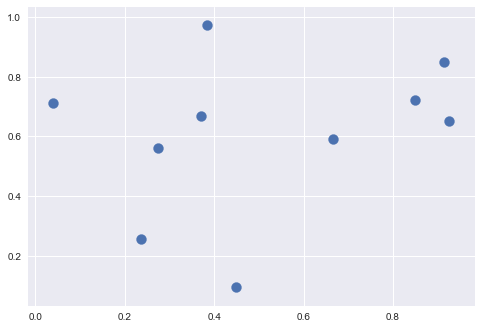

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points.
Recall that the squared-distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [31]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [32]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [33]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [34]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [35]:
dist_sq.diagonal()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

It checks out!
With the pairwise square-distances converted, we can now use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [36]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 7 1 4 3 6 5 2 8 9]
 [1 7 0 4 6 3 5 9 2 8]
 [2 8 5 4 3 0 9 7 6 1]
 [3 5 6 4 9 8 7 0 1 2]
 [4 7 0 3 1 5 6 2 8 9]
 [5 3 9 8 4 6 2 7 0 1]
 [6 3 5 9 4 7 1 0 8 2]
 [7 0 1 4 3 6 5 2 8 9]
 [8 2 5 3 9 4 6 7 0 1]
 [9 5 3 6 8 4 2 7 1 0]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the ``np.argpartition`` function:

In [37]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors:

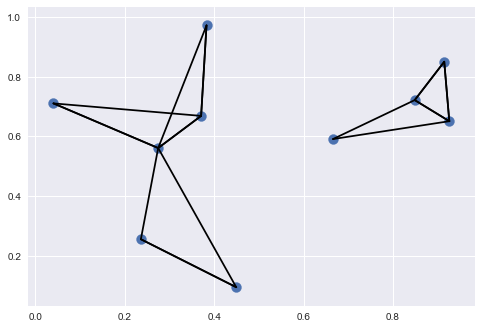

In [41]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

<!--NAVIGATION-->
< [Fancy Indexing](02.07-Fancy-Indexing.ipynb) | [Contents](Index.ipynb) | [Structured Data: NumPy's Structured Arrays](02.09-Structured-Data-NumPy.ipynb) >